# Train a variational autoencoder to perform clustering on the MNIST data set. Part 3.

With this exercises I'm trying to learn the basics of training an ANN with Keras.

The objective is to construct a VAE and pre-train it on the MNIST data set, then add a layer that performs clustering on the embeddings and fine-tune the model balancing the three losses:
- Reconstruction loss (ensure that it extracts good latent features, so we can reconstruct the input from the embeddings).
- KL-divergence loss (ensure that the mebeddings follow a mixture of gaussians distribution, so that we can infer some mining on the latent space and are able to generate new images).
- Clustering loss (ensure that we achieve good clustering quality).

---

**In this third part,** I will load the pretrained model from part 1 and add a clustering layer.

The main objective is to learn how to implement the clustering layer. (It was more difficult than I expected and had to rewrite the initial VAE multiple times in order to make it work.)

# Prepare some things...

First, we will import the necessary libraries and the MNIST data set. Then wee will define some functions we will reuse from part 1. An finally, we will construct our VAE and load the pre-trained weights from part 1.

## Import libraries

In [1]:
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical

from sklearn.cluster import KMeans
import sklearn.metrics

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Load and prepare the MNIST data set

In [2]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

In [3]:
x_train = np.expand_dims(x_train, -1).astype("float")/255
x_test = np.expand_dims(x_test, -1).astype("float")/255

## Reuse some functions

In [4]:
def kmeans_crosstab(x, y, k=10):
    kmeans = KMeans(n_clusters=k, n_init=30)
    kmeans.fit(x)

    confusion_matrix = sklearn.metrics.confusion_matrix(y, kmeans.labels_)
    heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
    heatmap.set(xlabel='clusters', ylabel='true labels')

    return kmeans

In [5]:
def kmeans_performance(kmeans, true_labels):
    confusion_matrix = sklearn.metrics.confusion_matrix(true_labels, kmeans.labels_)
    clust_labels = confusion_matrix.argmax(0)[kmeans.labels_]

    acc = sklearn.metrics.accuracy_score(y_test, clust_labels)
    print("Acc: %0.4f" % acc)
    print("ARI: %0.4f" % sklearn.metrics.adjusted_rand_score(true_labels, kmeans.labels_))
    print("AMI: %0.4f" % sklearn.metrics.adjusted_mutual_info_score(true_labels, kmeans.labels_))
    # X = points passed to Kmeans
    # print("Sil:", sklearn.metrics.silhouette_score(X, true_labels))

In [6]:
def plot_latent_space(z, labels, centroids = None, figsize=(10,10), legend_title = "Labels", alpha=0.2):
    """
    Draw a 2D scatterplot of the latent space
    """
    
    plt.figure(figsize=figsize)
    scatter = plt.scatter(z[:,0], z[:,1], label=labels, c=labels, cmap="tab10", alpha=alpha, linewidths=0)

    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], c="black", marker="x")
        
    leg = plt.legend(*scatter.legend_elements(), title=legend_title)
    # Make points in legend opaque
    for lh in leg.legendHandles: 
        # lh._legmarker.set_alpha(1) # old version of matplotlib
        lh.set_alpha(1)

    plt.show()

In [7]:
def plot_clusters_vs_labels(z, labels, clusters, centroids = None, figsize=(16,8), alpha=0.2):
    """
    Draw two 2D scatterplots of the latent space side by side 
    to compare the cluster assignments with the original labels
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    for ax, lab, title in zip(axes, (clusters, labels), ("Clusters", "Labels") ):
    
        scatter = ax.scatter(z[:,0], z[:,1], label=lab, c=lab, cmap="tab10", alpha=alpha, linewidths=0)

        leg = ax.legend(*scatter.legend_elements(), title=title)
        # Make points in legend opaque
        for lh in leg.legendHandles: 
            # lh._legmarker.set_alpha(1) # old version of matplotlib
            lh.set_alpha(1)
            
        if centroids is not None:
            ax.scatter(centroids[:,0], centroids[:,1], c="black", marker="x")

    plt.tight_layout()

In [8]:
def compare(dataset, encoder, decoder, labels, old_figure=None, n=5):
    """
    Takes the first n images of the dataset, passes them through the encoder and decoder,
    and shows a comparison of the original and reconstructed images.
    
    If an old_figure is passed, it adds a column to it with the new reconstruction. 
    """
    index = np.arange(0,n)
    res = 28
       
    if old_figure is not None:
        assert old_figure.shape[0] == n*res
        figure = np.zeros((old_figure.shape[0], old_figure.shape[1]+res))
        figure[0:old_figure.shape[0], 0:old_figure.shape[1]] = old_figure
    else:
        figure = np.zeros((n*res, 2*res))
        for i in index:
            figure[i*res:(i+1)*res, 0:res] = dataset[i].reshape(res, res)
    
    for i in index:
        z = encoder.predict(dataset[[i]], verbose=0)
        reconstructed = decoder.predict(z, verbose=0).reshape(res, res)
        figure[i*res:(i+1)*res, figure.shape[1]-res:figure.shape[1]] = reconstructed

    plt.figure()
    # plt.axis("off")
    
    x_ticks = np.arange(res/2, figure.shape[1], res)
    assert len(labels) == len(x_ticks)
    plt.xticks(x_ticks, labels, rotation=90)
    plt.yticks([])
    
    plt.imshow(figure, cmap="Greys_r")
    
    return figure

## Construct the VAE

### Encoder

In [9]:
class ConvBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.conv1 = layers.Conv2D(filters, 3, padding="same")
        self.conv2 = layers.Conv2D(filters, 3, padding="same")
        self.strides = layers.Conv2D(filters, 3, strides=2, padding="same")
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.5)
        
    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.strides(x)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return x

In [10]:
class Encoder(keras.Model):
    def __init__(self, latent_dim = 2, name=None):
        super(Encoder, self).__init__(name=name)
        self.latent_dim = latent_dim
        self.conv_block_1 = ConvBlock(32)
        self.conv_block_2 = ConvBlock(64)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(16, activation="relu")
        self.z_mean = layers.Dense(self.latent_dim, name="z_mean")
        self.z_log_var = layers.Dense(self.latent_dim, name="z_log_var")

    def call(self, encoder_inputs):
        x = self.conv_block_1(encoder_inputs)
        x = self.conv_block_2(x)
        x = self.flatten(x)
        x = self.dense(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        
        # Custom loss: KL-divergence
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(kl_loss)
        self.add_loss(kl_loss)
        # Add it also as a metric so it will show on the training output
        self.add_metric(kl_loss, name="kl_loss")
        
        return (z_mean, z_log_var)

In [11]:
latent_dim = 2
encoder = Encoder(latent_dim = latent_dim, name="encoder")

### Sampler and decoder

In [12]:
class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
class DeconvBlock(layers.Layer):
    def __init__(self, filters):
        super().__init__()
        self.stridesT = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")
        self.convT1 = layers.Conv2DTranspose(filters, 3, padding="same")
        self.convT2 = layers.Conv2DTranspose(filters, 3, padding="same")
        self.bn = layers.BatchNormalization()
        self.dropout = layers.Dropout(0.5)
        
    def call(self, inputs, training=False):
        x = self.stridesT(inputs)
        x = self.convT1(x)
        x = self.convT2(x)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        x = self.dropout(x, training=training)
        return x

In [14]:
class Decoder(keras.Model):
    def __init__(self, name=None):
        super(Decoder, self).__init__(name=name)
        self.dense = keras.layers.Dense(7 * 7 * 64, activation="relu")
        self.reshape = layers.Reshape((7, 7, 64))
        self.deconv_block_1 = DeconvBlock(64)
        self.deconv_block_2 = DeconvBlock(32)
        self.outputs = layers.Conv2D(1, 3,
                                      activation="sigmoid",
                                      padding="same",
                                      name="decoder_outputs")
        
    def call(self, decoder_inputs):
        x = self.dense(decoder_inputs)
        x = self.reshape(x)
        x = self.deconv_block_1(x)
        x = self.deconv_block_2(x)
        decoder_outputs = self.outputs(x)
        
        return decoder_outputs

In [15]:
decoder = Decoder(name="decoder")

### VAE model

In [16]:
encoder_inputs = keras.Input(shape=(28, 28, 1), name="encoder_inputs")
z_mean, z_log_var = encoder(encoder_inputs)
z = Sampler(name="sampler") (z_mean, z_log_var)
decoder_outputs = decoder(z)

vae = keras.Model(encoder_inputs, decoder_outputs, name='vae')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Encoder)              ((None, 2),          161812      ['encoder_inputs[0][0]']         
                                 (None, 2))                                                       
                                                                                                  
 sampler (Sampler)              (None, 2)            0           ['encoder[0][0]',                
                                                                  'encoder[0][1]']                
                                                                                                

### Define the reconstruction loss function

In [17]:
# Define the custom loss 
def reconstruction_loss(x, y):
    loss = tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(x, y),
            axis=(1, 2)
        )
    )
    return loss

### Load the pre-trained weights

In [18]:
vae.load_weights("models/vae_full/weights")

# Clustering VAE model

## Construct the clustering model

### Define a subclassed clustering layer

First, we define a subclassed layer that will take care of the clustering part.

It will take the same samples from the latent space that we feed to the decoder, and output cluster soft assignments, computed as a function of the distance to each cluster. The cluster centroids are saved as the layer weights.

In [19]:
class Clustering(layers.Layer):
    def __init__(self, n_clusters, name=None):
        super(Clustering, self).__init__(name=name)
        self.n_clusters = n_clusters

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        # Cluster centroids
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.n_clusters, input_dim),
                                        initializer='glorot_uniform',
                                        trainable=True,
                                       )
   
    def call(self, inputs, training=False):
        """
        Compute cluster assignments:
        
        z = inputs  - - - - - - - - - - - - - - (None, 2)
        mu = self.clusters  - - - - - - - - - - (10, 2)
        
        d_ij = ||z_i - mu_j||^2 - - - - - - - - (None, 10)
        
        q_ij = (1 + d_ij) / Sum_j'(1 + d_ij') - (None, 10)
        
        """
        
        # Taken from https://github.com/Tony607/Keras_Deep_Clustering/blob/master/Keras-DEC.ipynb:
        q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2)))
        q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        
        return q

### Construct the model

Now we can construct the model. It will output both the decoder outputs (reconstructed image) and the soft cluster assignments.

In [20]:
encoder_inputs = keras.Input(shape=(28, 28, 1), name="encoder_inputs")
z_mean, z_log_var = encoder(encoder_inputs)
z = Sampler(name="sampler") (z_mean, z_log_var)
decoder_outputs = decoder(z)

clust_outputs = Clustering(10, name="clustering") (z)

cvae = keras.Model(encoder_inputs, [decoder_outputs, clust_outputs], name='class_vae')
cvae.summary()

Model: "class_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 encoder (Encoder)              ((None, 2),          161812      ['encoder_inputs[0][0]']         
                                 (None, 2))                                                       
                                                                                                  
 sampler (Sampler)              (None, 2)            0           ['encoder[1][0]',                
                                                                  'encoder[1][1]']                
                                                                                          

### Define the clustering loss

We need to define a clustering loss. As in https://arxiv.org/abs/1511.06335v2, we take the soft cluster assignmentes as a distribution Q, compute an auxiliary distribution P (that depends on Q) and compute the KL-divergence of the two distributions as the loss function.

In [21]:
# Define the custom loss function:
def clustering_loss(Q, P):
    return tf.reduce_sum(tf.keras.losses.kld(Q, P))


# Define a function that will update the auxiliary distribution.
# We will call it every N epochs using callbacks:
def update_cvae_P(epoch, logs):
    global cvae_P
    
    N = 10
    if (epoch > 0) and (epoch % N == 0):
    
        # Get the soft assignments
        _, Q = cvae.predict(x_train)
        
        # Compute the auxilary distribution
        """
                          q_ij^2 / f_j
        P = {p_ij} = -------------------------
                      Sum_ij' (q_ij^2 / f_j')
        
        """
        # Taken from https://github.com/Tony607/Keras_Deep_Clustering/blob/master/Keras-DEC.ipynb:
        weight = Q ** 2 / tf.reduce_sum(Q, axis=0)
        P = tf.transpose(tf.transpose(weight) / tf.reduce_sum(weight, axis=1))
        
        # Save as numpy array (not strictly necessary, but easier to debug)
        cvae_P = P.numpy()
        print("Auxiliary distribution updated with current soft assignments.")

        
# Update the callbacks list so that it calls our function at the end of each epoch:
callbacks_list = [
   tf.keras.callbacks.LambdaCallback(
       on_epoch_end=update_cvae_P,
   )
]

### Initialize the centroids with k-means

Before we start training, we need to initialize the centroids (otherwise, they will be set randomly). We will compute them using the K-means algorithm:

In [22]:
z_train, _ = encoder.predict(x_train)
kmeans = KMeans(n_clusters=10, n_init=30)
kmeans.fit(z_train)

1875/1875 [==============================] - 6s 2ms/step


KMeans(n_clusters=10, n_init=30)

Now we can update the centroids on the clustering layer weights. Also, we will initialize our auxiliary distribution P with the cluster assignments from K-means. We have to one-hot encode the cluster assignments so that we can input it as a network target.

In [23]:
# Inicial weights (centroids)
cvae.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

# Initial auxiliary distribution (cluster assignments)
cvae_P = to_categorical(kmeans.labels_)

### Train the model and save the weights

Now we can compile and train our model. We need to specify the loss function we want to use for each output (`decoder` and `clustering`).

In [24]:
cvae.compile(optimizer="adam", #tf.keras.optimizers.Adam(learning_rate=0.00001),
             loss={"decoder":reconstruction_loss,
                  "clustering":clustering_loss,
                  })

Also, we specify the targets for each output: the input image for the `decoder` output, and the auxiliary distribution for the `clustering` output. We won't be using a validation set this time.

In [ ]:
cvae.fit(x_train, 
         {"decoder": x_train,
          "clustering": cvae_P,
         },
        epochs=50,
        batch_size=128,
        callbacks = callbacks_list,
       )

In [47]:
# encoder.save_weights("models/clustering_encoder/weights")
# decoder.save_weights("models/clustering_decoder/weights")
# cvae.save_weights("models/clustering_full/weights")

### Or load the weights

In [25]:
# encoder.load_weights("models/clustering_encoder/weights")
# decoder.load_weights("models/clustering_decoder/weights")
cvae.load_weights("models/clustering_full/weights")

## Plot the embeddings

Let's compute the new embeddings and plot them:

In [26]:
z_test, _ = encoder.predict(x_test)
_, c_test = cvae.predict(x_test)
c_test = c_test.argmax(1)

313/313 [==============================] - 2s 3ms/step


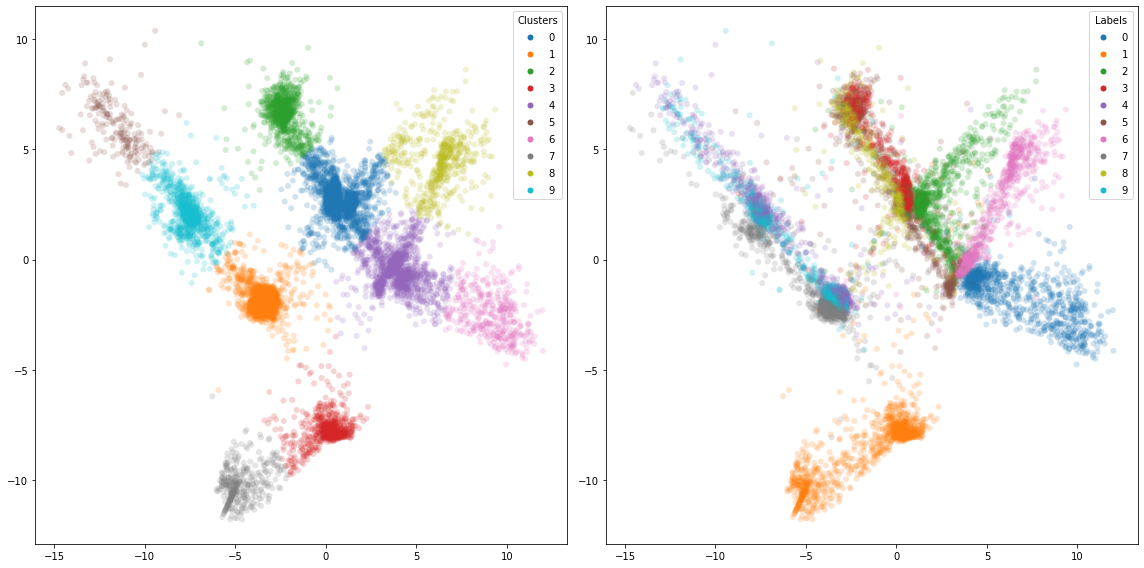

In [27]:
plot_clusters_vs_labels(z_test, y_test, c_test)

The clusters don't adjust at all to the labels, they are better defined. It doesn't look like training for more epochs will improve the situation. Maybe we the clustering loss is affecting too much to the gradients and we should adjust the loss weights?

Or maybe the inicial distribution on the latent space does not lead itself to good clustering...

## Evaluate the model

Obviously, the performance is not good either:

Acc: 0.4749
ARI: 0.3645
AMI: 0.5506


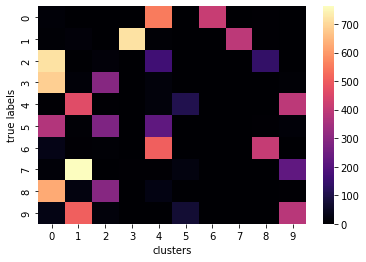

In [27]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, c_test)
heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='true labels')

clust_labels = confusion_matrix.argmax(0)[c_test]

print("Acc: %0.4f" % sklearn.metrics.accuracy_score(y_test, clust_labels))
print("ARI: %0.4f" % sklearn.metrics.adjusted_rand_score(y_test, clust_labels))
print("AMI: %0.4f" % sklearn.metrics.adjusted_mutual_info_score(y_test, clust_labels))

# ToDo:

## Save full model
- Investigate how to save (and load) the models as full models (not only weights).

## Improve clustering performance
- Train for more epochs?
- Change auxiliary distribution update frequency?
- Different initial latent space (pre-training)?
- Modify the loss weights?
- Change the learning rate?